# Linear fit for the ON/OFF sound pattern in non-speech fragments

In [2]:
import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import statsmodels.api as sm
from utils import load_fragment_times, zscore, shuffle_fragments

%matplotlib inline

In [6]:
hdir = '../data/'
speech = load_fragment_times(hdir, 'speech')
nonspeech = load_fragment_times(hdir,'nonspeech')
a = np.load('../data/audio_envelope_100Hz.npy')
sound_onoff = np.load('../data/sound_on_off_100Hz.npy')

In [5]:
subj = 's1'
x    = np.load('../data/' + subj + '_HD_100Hz_hfb.npy')
pm = np.load('../results/ttest_ecog_speech_nonspeech_'+subj+'_pmask.npz')['pmask_bonf'] # pmask from the first ttest
grid = np.load('../data/' + subj + '_HD_grid.npy')
n = x.shape[-1]

In [8]:
# shift to max cor lag per fragment
D = np.load('../results/xcor_' + subj + '_audio_envelope_100Hz_hfb_spearman.npz')
start = 400
r_non = D['r_non'][:,:,start:-349]
rm = np.argmax(r_non, 2)

maxr = np.zeros(rm.shape)
for i, f in enumerate(rm):
    for ir, r in enumerate(f):
        maxr[i, ir] = r_non[i, ir][rm[i, ir]]

offset = 400 - start
rm = rm - offset

In [9]:
# select fragments and concatenate over time
x_non, o_non = [], []
for ifrag, non_frag in enumerate(nonspeech):
    x_non.append([])
    o_non.append(sound_onoff[range(non_frag[0], non_frag[1])])
    for i in range(n):
        x_non[-1].append(x[range(non_frag[0]+rm[ifrag, i], non_frag[1]+rm[ifrag, i]), i])
x_non = np.array(x_non)
o_non = np.array(o_non)

x_non_c = x_non.swapaxes(1, 2).reshape((-1, n))
o_non_c = o_non.reshape(-1, )

In [10]:
# find ols
x_non_cz = zscore(x_non_c)
o_basis = np.vstack([np.ones(o_non_c.shape[0]), o_non_c]).T

x_betas, x_sumres, _, _ = linalg.lstsq(o_basis, x_non_cz)

x_fit = o_basis.dot(x_betas)
x_rsd = x_non_cz - x_fit

In [11]:
# beta weights
bs_masked = zscore(x_betas[1]).copy()
#bs_masked = x_betas[1].copy()
bs_masked[np.setdiff1d(range(n), pm)] = 0

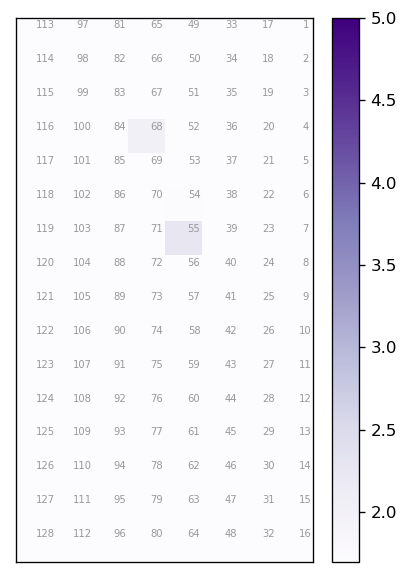

In [13]:
# display beta weights for s1
plt.figure(figsize=(4, 6), dpi=120)
cmap = plt.get_cmap('Purples')
cmap.set_bad((.7, .7, .7))
plt.imshow(bs_masked[grid], aspect='auto', cmap = cmap, vmin = 1.7, vmax = 5, extent=[0, grid.shape[-1], 0, grid.shape[0]]) # for zscored
# plt.imshow(bs_masked[grid], aspect='auto', cmap = cmap, vmin = 0, vmax = 1, extent=[0, grid.shape[-1], 0, grid.shape[0]]) # for non-zscored
for (i, j), k in np.ndenumerate(np.flipud(grid)):
    plt.gca().text(j+.8, i+.8, k+1, ha='center', va='center', color=(.6, .6, .6), fontsize=6)
plt.xticks([])
plt.yticks([])
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.colorbar()
plt.show()

In [14]:
# shift testing
sm_f, sm_fp, sm_ts, sm_tps, sm_w = [], [], [], [], []
for i in range(n):
    est = sm.OLS(x_non_cz[:, i], o_basis)
    est2 = est.fit()
    sm_f.append(est2.fvalue)
    sm_fp.append(est2.f_pvalue)
    sm_ts.append(est2.tvalues)
    sm_tps.append(est2.pvalues)
    sm_w.append(est2.params)
sm_f, sm_fp, sm_ts, sm_tps, sm_w  = np.array(sm_f), np.array(sm_fp), np.array(sm_ts), np.array(sm_tps), np.array(sm_w)

In [15]:
# permutation baseline
nperms = 10000
sm_fs_perm, sm_ts_perm, sm_tps_perm, sm_w_perm = [], [], [], []
for i in range(n):
    sm_fs_perm.append([])
    sm_ts_perm.append([])
    sm_tps_perm.append([])
    sm_w_perm.append([])
    for perm in range(10000):
        est = sm.OLS(shuffle_fragments(x_non_cz[:, i]), o_basis)
        est2 = est.fit()
        sm_fs_perm[-1].append(est2.fvalue)
        sm_ts_perm[-1].append(est2.tvalues)
        sm_tps_perm[-1].append(est2.pvalues)
        sm_w_perm[-1].append(est2.params)

In [16]:
sm_fs_perm, sm_ts_perm, sm_tps_perm, sm_w_perm  = np.array(sm_fs_perm), np.array(sm_ts_perm), np.array(sm_tps_perm), np.array(sm_w_perm)
prcnl = np.percentile(sm_ts_perm[:, :, -1], 100-.001/n, axis=1)
print(prcnl[pm])
print(sm_ts[pm, -1])

[20.01859423 19.78111844 18.48315554 17.18205647 13.71282175 17.16731485
 26.60841952 18.4112131  17.00677999 17.05584952 15.46619076 18.89471821
 17.12153649 17.59581927 14.70588851 14.37612778 17.61781346 13.41705885
 16.04298349 16.66718369]
[19.0801852  10.06906902 13.75721271 24.30972543 26.19588599 29.02601529
 27.81776256 21.07700146 25.94696562 18.20640138 20.23989565 25.08283312
 15.70820322  6.92974495 19.70935921 16.38380047 12.61003202 19.0517003
 11.86265228 13.45885703]


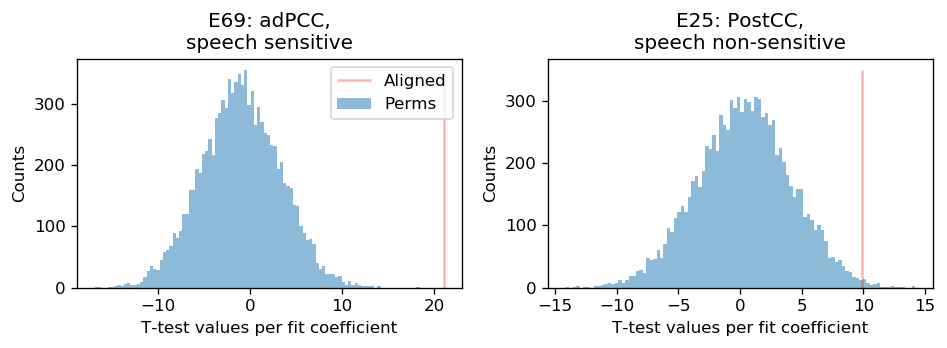

In [17]:
plt.figure(figsize=(8, 3), dpi=120)
plt.subplot(121)
plt.hist(sm_ts_perm[68,:,-1], 100, alpha=.5)
plt.vlines(x=sm_ts[68, -1], ymin=0, ymax=350, color='red', alpha=.3)
plt.ylabel('Counts')
plt.xlabel('T-test values per fit coefficient')
plt.title('E69: adPCC,\nspeech sensitive')
plt.legend(['Aligned', 'Perms'])

plt.subplot(122)
plt.hist(sm_ts_perm[24,:,-1], 100, alpha=.5)
plt.vlines(x=sm_ts[27, -1], ymin=0, ymax=350, color='red', alpha=.3)
plt.ylabel('Counts')
plt.xlabel('T-test values per fit coefficient')
plt.title('E25: PostCC,\nspeech non-sensitive')
plt.tight_layout()
plt.show()